<h2> BERT for analysing tweets: Real or Not? Disaster Tweets</h2>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
nltk.download()
#from nltk.corpus import stopwords
#from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

plt.style.use("ggplot")
stop=set(stopwords.words("english"))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/My Drive/Tweets

/content/gdrive/My Drive/Tweets


In [ ]:
train = pd.read_csv("train-2.csv")

In [ ]:
train.shape

(7613, 5)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## EDA

Target Class Distribution

In [ ]:
plt.rcParams["figure.figsize"] = [8,4]
plt.rcParams["figure.dpi"] = 80

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


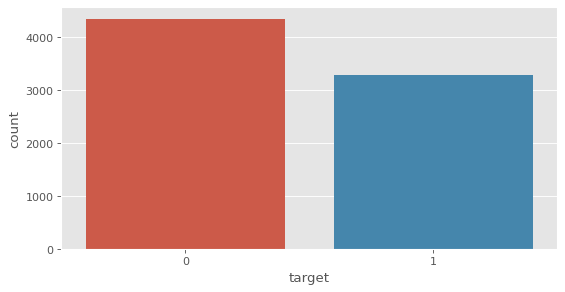

In [ ]:
sns.countplot("target", data=train)

In [ ]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

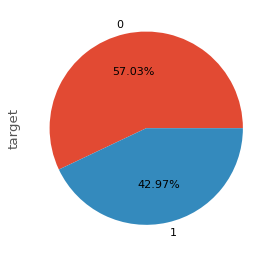

In [ ]:
train["target"].value_counts().plot.pie(autopct="%1.2f%%")

Tweet Length Distribution

In [ ]:
# nltk.download()

In [ ]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


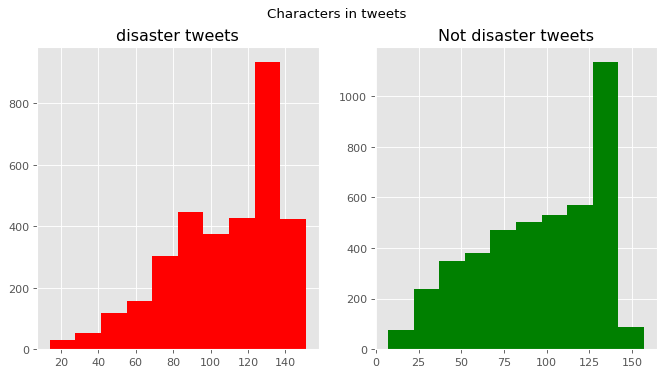

In [ ]:
# character frequency in tweets

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train["target"]==1]["text"].str.len()
ax1.hist(tweet_len,color="red")
ax1.set_title("disaster tweets")
tweet_len=train[train["target"]==0]["text"].str.len()
ax2.hist(tweet_len,color="green")
ax2.set_title("Not disaster tweets")
fig.suptitle("Characters in tweets")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

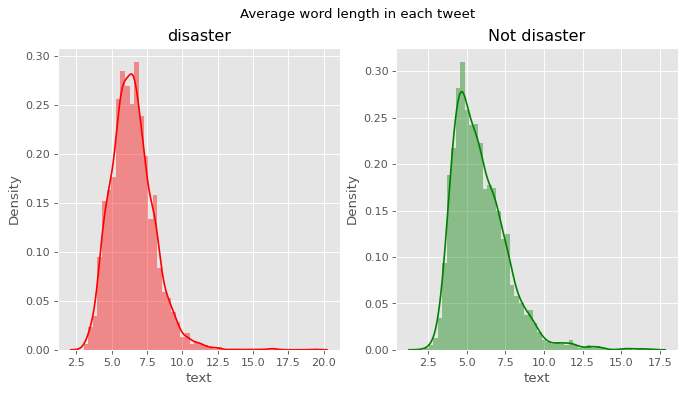

In [ ]:
# tweet average word length

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train["target"]==1]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color="red")
ax1.set_title("disaster")
word=train[train["target"]==0]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color="green")
ax2.set_title("Not disaster")
fig.suptitle("Average word length in each tweet")

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train["target"]==target]["text"].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
# find common stopwords for class 0

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

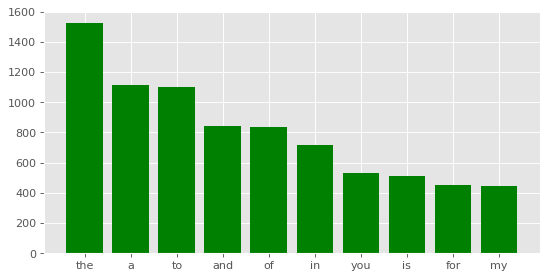

In [ ]:
x,y=zip(*top)
plt.bar(x,y,color="green")

In [ ]:
# find common stopwords for class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

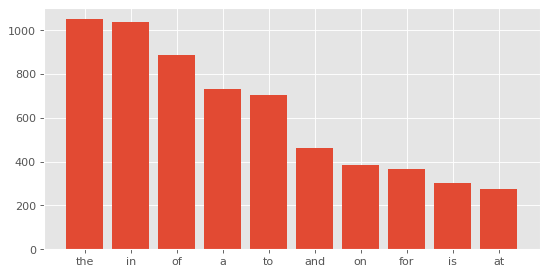

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

In [ ]:
# punctuation in class 0

corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

<BarContainer object of 20 artists>

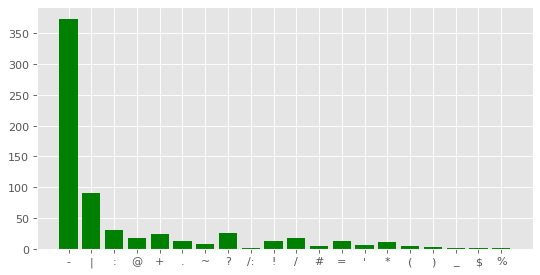

In [ ]:
x,y=zip(*dic.items())
plt.bar(x,y,color="green")

In [ ]:
# punctuation in class 1

corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

<BarContainer object of 18 artists>

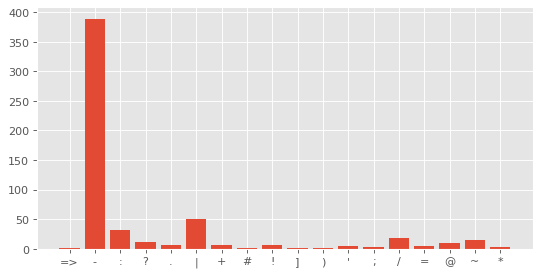

In [ ]:
x,y=zip(*dic.items())
plt.bar(x,y)

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

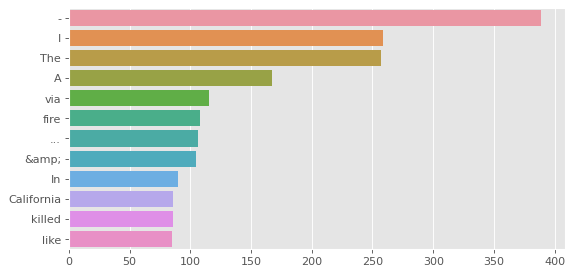

In [ ]:
sns.barplot(x=y,y=x)

In [ ]:
# ngram analysis

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

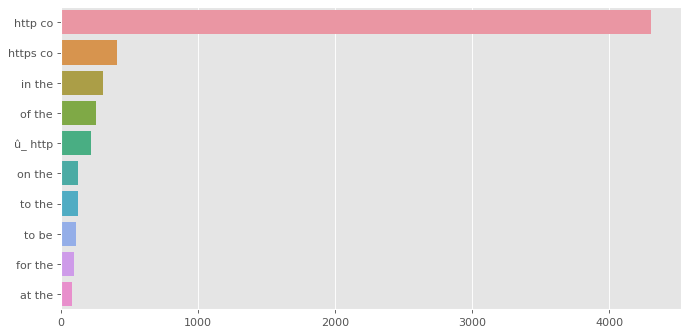

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train["text"])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [ ]:
# data cleaning

test = pd.read_csv("test-2.csv")

In [ ]:
tweets = pd.concat([train, test])
tweets.shape

(10876, 5)

In [ ]:
# remove URL

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x : remove_URL(x))

In [ ]:
# remove HTML tags

def remove_html(text):
    html=re.compile(r"<.*?>")
    return html.sub(r"",text)

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x : remove_html(x))

In [ ]:
# remove Emojis

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"", text)

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x: remove_emoji(x))

In [ ]:
# remove punctuation

def remove_punct(text):
    table=str.maketrans("","",string.punctuation)
    return text.translate(table)

In [ ]:
tweets["text"] = tweets["text"].apply(lambda x : remove_punct(x))

In [ ]:
# correct incorrect spelling

In [ ]:
# !pip install pyspellchecker

In [ ]:
"""from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text) """

'from spellchecker import SpellChecker\n\nspell = SpellChecker()\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text) '

In [ ]:
#tweets["text"] = tweets["text"].apply(lambda x : correct_spellings(x))

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
!pip install sentencepiece

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

     |████████████████████████████████| 1.1MB 11.7MB/s 


In [ ]:
# load CSV files containing training data
train = pd.read_csv("train-2.csv")
test = pd.read_csv("test-2.csv")

In [ ]:
# download BERT layer
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
# load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation="sigmoid")(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [ ]:
# encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
# build BERT model with my tuning
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# train BERT model with my tuning
checkpoint = ModelCheckpoint("model_BERT.h5", monitor="val_loss", save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = 0.2,
    epochs = 3, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = 16
)

Epoch 1/3
381/381 [==============================] - 730s 2s/step - loss: 0.4272 - accuracy: 0.8182 - val_loss: 0.3926 - val_accuracy: 0.8424
Epoch 2/3
381/381 [==============================] - 651s 2s/step - loss: 0.2740 - accuracy: 0.8923 - val_loss: 0.3975 - val_accuracy: 0.8352
Epoch 3/3
381/381 [==============================] - 650s 2s/step - loss: 0.1467 - accuracy: 0.9450 - val_loss: 0.4635 - val_accuracy: 0.8313


In [ ]:
# prediction by BERT model with my tuning
model_BERT.load_weights("model_BERT.h5")
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype("int")

In [ ]:
# prediction by BERT model with my tuning for the training data - for the Confusion Matrix
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype("int")

In [ ]:
# show Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt="", ax=ax)

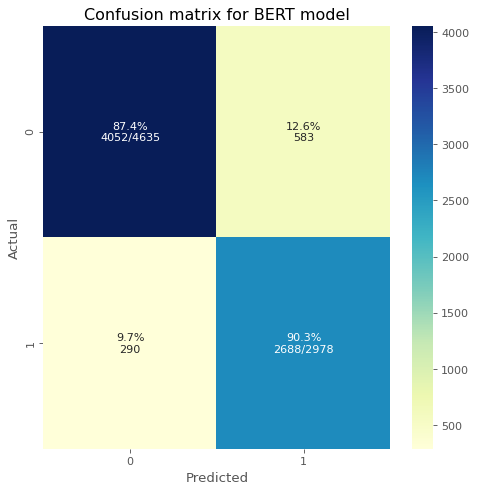

In [ ]:
# show Confusion Matrix for BERT model
from sklearn.metrics import classification_report,confusion_matrix
plot_cm(train_pred_BERT_int, train["target"].values, "Confusion matrix for BERT model", figsize=(7,7))